In [1]:
import tensorflow as  tf
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from pathlib import Path
import shutil
import datetime

In [2]:
sys.path.append('../utils')

In [3]:
from data_preparing import ChannelData, random_rotation
from model import ChannelCutter
from focal_tversky_loss import *

In [6]:
train_data = ChannelData(
    path=Path('../data/crop_512x320/train'),
    elevation='elevation'
)
val_data = ChannelData(
    path=Path('../data/crop_512x320/val'),
    elevation='elevation'
)
train_data.add_process(random_rotation)
val_data.add_process(random_rotation)

model = ChannelCutter({
    'input_shape': [512, 320, 4],
    'n_classes': 2
})


BATCH_SIZE = 2
BUFFER_SIZE = 6

train_dataset =  train_data.data\
    .shuffle(BUFFER_SIZE)\
    .batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset =  val_data.data\
    .shuffle(BUFFER_SIZE)\
    .batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

session_labels = ['crop512x320', 'no_rotation']
find_lr = True

In [5]:
from tensorflow.keras.callbacks import Callback


class LRFinder(Callback):
    """Callback that exponentially adjusts the learning rate after each training batch between start_lr and
    end_lr for a maximum number of batches: max_step. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the plot method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 336, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

Epoch 1/2
336/336 [==============================] - 165s 490ms/step - loss: 0.8485 - accuracy: 0.8005
Epoch 2/2
336/336 [==============================] - 165s 491ms/step - loss: 0.9430 - accuracy: 0.1209


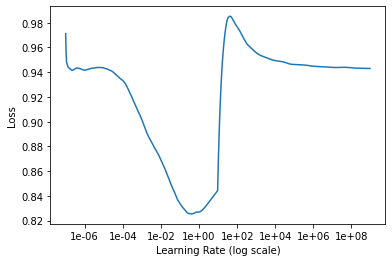

In [7]:
if find_lr:
    model.compile_model(
        optimizer='adam', 
        loss=reduced_iou_loss, 
        metrics=['accuracy']
    )

    lr_finder = LRFinder(start_lr=1e-7, end_lr=10, max_steps=336)
    model.unet.fit(
        train_dataset, epochs=2, 
        callbacks=[lr_finder]
    )
    
    lr_finder.plot()

In [8]:
model.unet.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 320, 4) 0                                            
__________________________________________________________________________________________________
input_conv (Conv2D)             (None, 512, 320, 32) 6304        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 512, 320, 32) 128         input_conv[0][0]                 
__________________________________________________________________________________________________
pre_unet_conv_step0 (Conv2D)    (None, 512, 320, 32) 9248        batch_normalization_24[0][0]     
_______________________________________________________________________________________

In [7]:
initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=300,
    decay_rate=0.1,
    staircase=True)

model.compile_model(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
    loss=reduced_iou_loss, 
    metrics=['accuracy', tp, tn]
)

session_labels.append('lr1e-3')
session_name = '_'.join(session_labels)
save_path = Path("./logs") / session_name / ('trained_on_'+str(datetime.datetime.now()))
os.makedirs(save_path)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=save_path)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# train_dataset =  train_data.data\
#     .shuffle(BUFFER_SIZE)\
#     .batch(BATCH_SIZE)\
#     .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# val_dataset =  val_data.data\
#     .shuffle(BUFFER_SIZE)\
#     .batch(BATCH_SIZE)\
#     .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

model.unet.fit(
    train_dataset, epochs=3, validation_data=val_dataset,
    callbacks=[tensorboard_callback, early_stopping_callback]
)

Epoch 1/3
  1/336 [..............................] - ETA: 0s - loss: 0.9434 - accuracy: 0.6137 - tp: 0.4722 - tn: 0.6177WARNING:tensorflow:From /home/yao/develop/channel_image_segmentation/.venv/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
336/336 [==============================] - 169s 503ms/step - loss: 0.5589 - accuracy: 0.9539 - tp: 0.6366 - tn: 0.9653 - val_loss: 0.5689 - val_accuracy: 0.9428 - val_tp: 0.7567 - val_tn: 0.9485
Epoch 2/3
336/336 [==============================] - 174s 517ms/step - loss: 0.4387 - accuracy: 0.9726 - tp: 0.6238 - tn: 0.9852 - val_loss: 0.4367 - val_accuracy: 0.9745 - val_tp: 0.6026 - val_tn: 0.9858
Epoch 3/3
336/336 [==============================] - 173s 516ms/step - loss: 0.4215 - accuracy: 0.9733 - tp: 0.6354 - tn: 0.9854 - val_loss: 0.4214 - val_accuracy

In [8]:
import json

In [9]:
with open(save_path / 'model_config.json', 'w') as fp:
    fp.write(str(model.unet.get_config()))

In [10]:
model_path = str(save_path).replace('logs', 'models')
os.makedirs(model_path)

In [11]:
model.unet.save(model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/crop512x320_no_rotation_lr1e-3/trained_on_2020-09-03 12:00:00.647990/assets


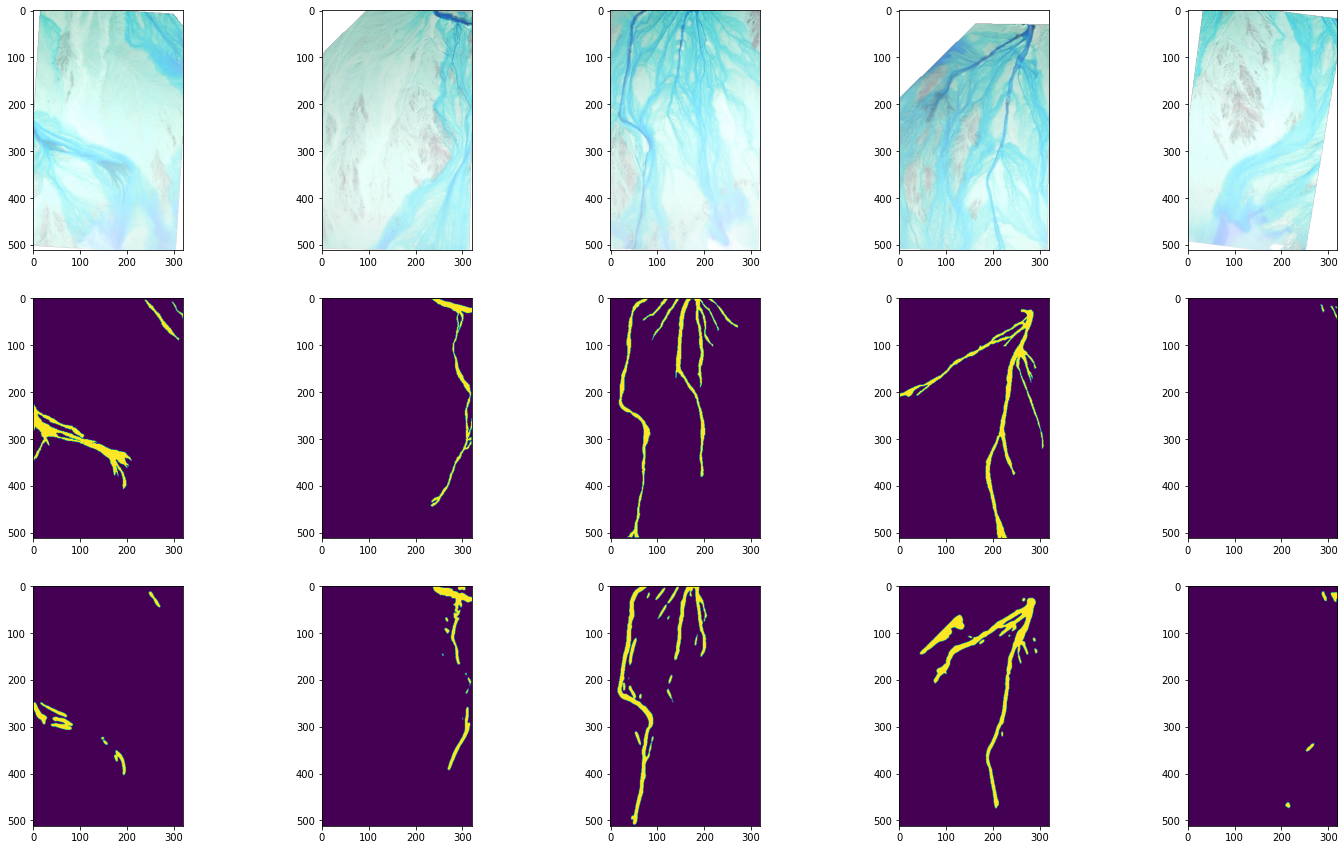

In [9]:
n_samples = 5

fig, axes = plt.subplots(nrows=3, ncols=n_samples, figsize=(n_samples*5, 15))
i = 0
for x, y in val_dataset.take(5):
    axes[0][i].imshow(x[0, :, : :])
    axes[1][i].imshow(y[0, :, : :])
    axes[2][i].imshow(model.unet.predict(x)[0, :, :, 1])
    i += 1
    
plt.show()